In [1]:
from tools import *
import json
#from webapp import *
import pyodbc
#IMPORT DATABASE FROM SQL SERVER AND FIT DATA JUST OFF OF THE DATABASE

In [2]:
server = 'wdtdevsql02'
database = 'WDT_PROD'
username= 'application'
password= '!v80VD8gX!vK'
pyodbc_cnntr = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password

In [3]:
'''server: wdtdevsql02
database: WDT_PROD
login: application
password: !v80VD8gX!vK'''

'server: wdtdevsql02\ndatabase: WDT_PROD\nlogin: application\npassword: !v80VD8gX!vK'

In [20]:
to_return = {}  
cnxn = pyodbc.connect(pyodbc_cnntr)
cursor = cnxn.cursor()    
cursor.execute("SELECT Frequency_Hz, Minus_Z_Imaginary_Ohm, Z_Real_Ohm FROM ACImpedanceData_Raw WHERE Cycle = 1 AND ProcessDataID = 737864")
for row in cursor.fetchall():
    to_return.update({row.Frequency_Hz: [row.Z_Real_Ohm, row.Minus_Z_Imaginary_Ohm]})
cnxn.close()

In [106]:
import pprint
pp = pprint.PrettyPrinter(width=41, compact=True)
#pp.pprint(to_return)

In [107]:
freq = pd.Series([np.float64(i) for i in list(to_return.keys())])
re = pd.Series([np.float64(i[0]) for i in list(to_return.values())])
im = pd.Series([np.float(i[1]) for i in list(to_return.values())])

In [108]:
#self, params, circuit, weight_func='modulus', nan_policy='raise', maxfev = 10
#minimize(self.leastsq_errorfunc, params, method='leastsq', args=(self.df[i].w.values, self.df[i].re.values, self.df[i].im.values, circuit, weight_func), nan_policy=nan_policy, maxfev=maxfev)
masked_mpt.df[0].w.values

array([6.28330217e+06, 5.59986811e+06, 4.99093949e+06, 4.44817984e+06,
       3.96441856e+06, 3.53330056e+06, 3.14917137e+06, 2.80660915e+06,
       2.50135787e+06, 2.22933679e+06, 1.98693150e+06, 1.77081858e+06,
       1.57825849e+06, 1.40662756e+06, 1.25376879e+06, 1.11735015e+06,
       9.95797723e+05, 8.87537247e+05, 7.91111464e+05, 7.05004430e+05,
       6.28341841e+05, 5.60015940e+05, 4.99093974e+05, 4.44817959e+05,
       3.96430213e+05, 3.53347568e+05, 3.14928811e+05, 2.80649247e+05,
       2.50159136e+05, 2.22933673e+05, 1.98681501e+05, 1.77111031e+05,
       1.57814200e+05, 1.40674405e+05, 1.25341900e+05, 1.11758357e+05,
       9.95739478e+04, 8.87303826e+04, 7.91111589e+04, 7.04829569e+04,
       6.28458583e+04, 5.60141553e+04, 4.99136090e+04, 4.44989848e+04,
       3.96326641e+04, 3.53181314e+04, 3.14888335e+04, 2.80634023e+04,
       2.50150836e+04, 2.22839167e+04, 1.98612191e+04, 1.77015878e+04,
       1.57758418e+04, 1.40608363e+04, 1.25389690e+04, 1.11733426e+04,
      

In [109]:
Rs_guess = min(re)
R1_guess = max(re)//4
n1_guess = random.uniform(0, 1)
q1_guess = random.uniform(0, .001)
R2_guess = 2*max(re)//4
n2_guess = random.uniform(0, 1)
q2_guess = random.uniform(0, .001)
Q3_guess = random.uniform(0, .001)
n3_guess = random.uniform(0, 1)
params = Parameters()
params.add('Rs', value=Rs_guess, min=Rs_guess*.001, max=Rs_guess*10)
params.add('R1', value=R1_guess, min=R1_guess*.001, max=R1_guess*10)
params.add('n1', value=n1_guess, min=0, max=1)
params.add('Q1', value=q1_guess, min=0, max=.001)
params.add('R2', value=R2_guess, min=R2_guess*.001, max=R2_guess*10)
params.add('n2', value=n2_guess, min=.01, max=1)
params.add('Q2', value=q2_guess, min=0, max=.001)
params.add('Q', value=Q3_guess, min=0, max=.001)
params.add('n', value=n3_guess, min=.01, max=1)

In [110]:
def leastsq_errorfunc(params, w, re, im, circuit, weight_func = 'modulus'):
        if circuit == 'R-RQ-RQ':
            re_fit = cir_RsRQRQ_fit(params, w).real
            im_fit = -cir_RsRQRQ_fit(params, w).imag
        elif circuit == 'R-RQ-Q':
            re_fit = cir_RsRQQ_fit(params, w).real
            im_fit = -cir_RsRQQ_fit(params, w).imag
        elif circuit == 'R-RQ-RQ2':
            re_fit = cir_RsRQRQ2_fit(params, w).real
            im_fit = -cir_RsRQRQ2_fit(params, w).imag
        elif circuit == 'R-RQ-RQ-Q':
            re_fit = cir_RsRQRQQ_fit(params, w).real
            im_fit = -cir_RsRQRQQ_fit(params, w).imag
        else:
            print('Circuit is not defined in leastsq_errorfunc()')

        error = ([(re-re_fit)**2, (im-im_fit)**2]) #sum of squares
        
        #Different Weighing options, see Lasia
        if weight_func == 'modulus':
            weight = [1/((re_fit**2 + im_fit**2)**(1/2)), 1/((re_fit**2 + im_fit**2)**(1/2))]
        elif weight_func == 'proportional':
            weight = [1/(re_fit**2), 1/(im_fit**2)]
        elif weight_func == 'unity':
            unity_1s = []
            for k in range(len(re)):
                unity_1s.append(1) #makes an array of [1]'s, so that the weighing is == 1 * sum of squres.
            weight = [unity_1s, unity_1s]
        else:
            print('weight not defined in leastsq_errorfunc()')
        
        S = np.array(weight) * error #weighted sum of squares 
        return S
    

In [115]:
circuit = 'R-RQ-RQ-Q'
weight_func = 'modulus'
nan_policy = 'raise'
maxfev = 5000
#MINIMIZE CANNOT TAKE IN LISTS
#IT MUST BE PD SERIES
#ALSO IT MUST BE CALLED SERIES.VALUES
#NOT JUST SERIES
fitted_data = minimize(leastsq_errorfunc, params, method='leastsq', args=(freq.values, re.values, im.values, circuit, weight_func), nan_policy=nan_policy, maxfev=maxfev)
print("CHI-SQ ERROR: ", fitted_data.chisqr)
print("PARAMS")
pp.pprint(fitted_data.params)

CHI-SQ ERROR:  16323195885.500374
PARAMS
Parameters([('Rs',
             <Parameter 'Rs', value=320.1427611608317 +/- 8.55e+03, bounds=[0.72993665:7299.3665]>),
            ('R1',
             <Parameter 'R1', value=22616521.919389043 +/- 1.59e+06, bounds=[6381.249:63812490.0]>),
            ('n1',
             <Parameter 'n1', value=0.8550350373604975 +/- 0.0133, bounds=[0:1]>),
            ('Q1',
             <Parameter 'Q1', value=3.977689074174951e-09 +/- 6.82e-11, bounds=[0:0.001]>),
            ('R2',
             <Parameter 'R2', value=13680.745512423224 +/- 3.24e+08, bounds=[12762.498:127624980.0]>),
            ('n2',
             <Parameter 'n2', value=0.4526393409937989 +/- 493, bounds=[0.01:1]>),
            ('Q2',
             <Parameter 'Q2', value=0.0002916831976338684 +/- 2.29, bounds=[0:0.001]>),
            ('Q',
             <Parameter 'Q', value=2.0060562370088908e-07 +/- 1.22e-06, bounds=[0:0.001]>),
            ('n',
             <Parameter 'n', value=0.6457808341

In [120]:
fitted_points = cir_RsRQRQQ(w=freq.values, Rs=fitted_data.params.get('Rs').value, Q=fitted_data.params.get('Q').value, n=fitted_data.params.get('n').value, R1=fitted_data.params.get('R1').value, Q1=fitted_data.params.get('Q1').value, n1=fitted_data.params.get('n1').value, fs1='None', R2=fitted_data.params.get('R2').value, Q2=fitted_data.params.get('Q2').value, n2=fitted_data.params.get('n2').value, fs2='None')

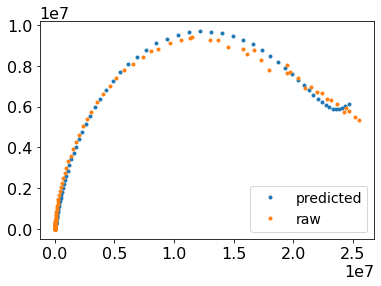

In [127]:
plt.plot(fitted_points.real, -fitted_points.imag, '.', label = 'predicted')
plt.plot(re, im, '.', label = 'raw')
plt.legend()